In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

                                               image  label
0  C:\Users\riyaz\.cache\kagglehub\datasets\nazmu...      1
1  C:\Users\riyaz\.cache\kagglehub\datasets\nazmu...      2
2  C:\Users\riyaz\.cache\kagglehub\datasets\nazmu...      0
3  C:\Users\riyaz\.cache\kagglehub\datasets\nazmu...      0
4  C:\Users\riyaz\.cache\kagglehub\datasets\nazmu...      1
Total images: 12446


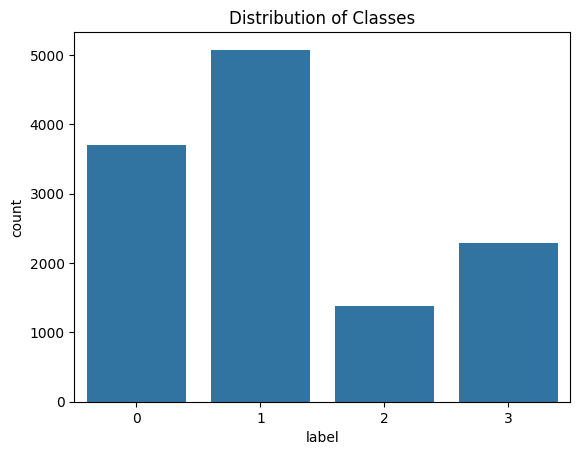

In [2]:
# Initializing path
data_dir = Path('C:/Users/riyaz/.cache/kagglehub/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

# Get the path to the sub-directories
Normal_Cases_dir = data_dir / 'Normal'
Cyst_Cases_dir = data_dir / 'Cyst'
Stone_Cases_dir = data_dir / 'Stone'
Tumor_Cases_dir = data_dir / 'Tumor'

# Getting the list of all the images
Normal_Cases = Normal_Cases_dir.glob('*.jpg')
Cyst_Cases = Cyst_Cases_dir.glob('*.jpg')
Stone_Cases = Stone_Cases_dir.glob('*.jpg')
Tumor_Cases = Tumor_Cases_dir.glob('*.jpg')

# An empty list for inserting data into this list in (image_path, Label) format
train_data = []

# Labeling the Cyst case as 0
for img in Cyst_Cases:
    train_data.append((img, 0))

# Labeling the Normal case as 1
for img in Normal_Cases:
    train_data.append((img, 1))

# Labeling the Stone case as 2
for img in Stone_Cases:
    train_data.append((img, 2))

# Labeling the Tumor case as 3
for img in Tumor_Cases:
    train_data.append((img, 3))

# Converting the list into a DataFrame
train_df = pd.DataFrame(train_data, columns=['image', 'label'])

# Shuffling the DataFrame
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Checking the data
print(train_df.head())
print(f'Total images: {len(train_df)}')

# Displaying count plot
sns.countplot(data=train_df, x='label')
plt.title('Distribution of Classes')
plt.show()

In [3]:
# Loading images and resizing them
def load_and_resize(image_path, size=(128, 128)):
    img = imread(str(image_path))
    img = cv2.resize(img, size)
    return img

# Creating X and y arrays
X = []
y = []

for index, row in train_df.iterrows():
    img = load_and_resize(row['image'])
    X.append(img)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

print(f'X shape: {X.shape}, y shape: {y.shape}')

# Normalizing the pixel values
X = X / 255.0

X shape: (12446, 128, 128, 3), y shape: (12446,)


In [11]:
# Splitting the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (7964, 128, 128, 3)
Validation data shape: (1992, 128, 128, 3)
Test data shape: (2490, 128, 128, 3)


In [12]:
# Loading the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the base model layers
base_model.trainable = False

# Adding custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
249/249 [==============================] - 53s 196ms/step - loss: 1.7202 - accuracy: 0.7271 - val_loss: 0.9040 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 2/50
249/249 [==============================] - 47s 189ms/step - loss: 0.7870 - accuracy: 0.8680 - val_loss: 0.5501 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 3/50
249/249 [==============================] - 47s 189ms/step - loss: 0.5825 - accuracy: 0.8990 - val_loss: 0.4522 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 4/50
249/249 [==============================] - 47s 189ms/step - loss: 0.5240 - accuracy: 0.8982 - val_loss: 0.3905 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 5/50
249/249 [==============================] - 47s 189ms/step - loss: 0.4896 - accuracy: 0.9078 - val_loss: 0.4593 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 6/50
249/249 [==============================] - 47s 187ms/step - loss: 0.4797 - accuracy: 0.9029 - val_loss: 0.3830 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 7/50
249/249 [==============================] 

78/78 [==============================] - 12s 154ms/step - loss: 0.1363 - accuracy: 0.9871
Test Accuracy: 98.71%
78/78 [==============================] - 13s 148ms/step


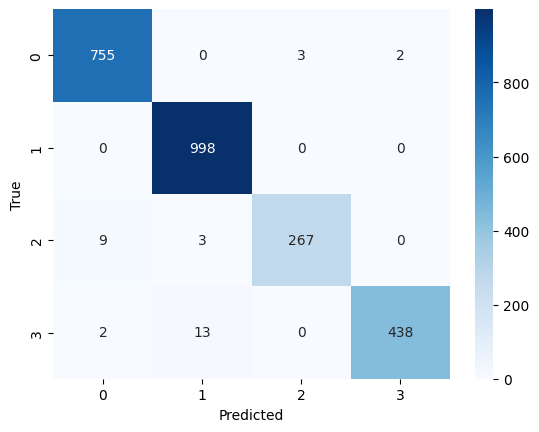

              precision    recall  f1-score   support

        Cyst       0.99      0.99      0.99       760
      Normal       0.98      1.00      0.99       998
       Stone       0.99      0.96      0.97       279
       Tumor       1.00      0.97      0.98       453

    accuracy                           0.99      2490
   macro avg       0.99      0.98      0.98      2490
weighted avg       0.99      0.99      0.99      2490



In [14]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=['Cyst', 'Normal', 'Stone', 'Tumor']))

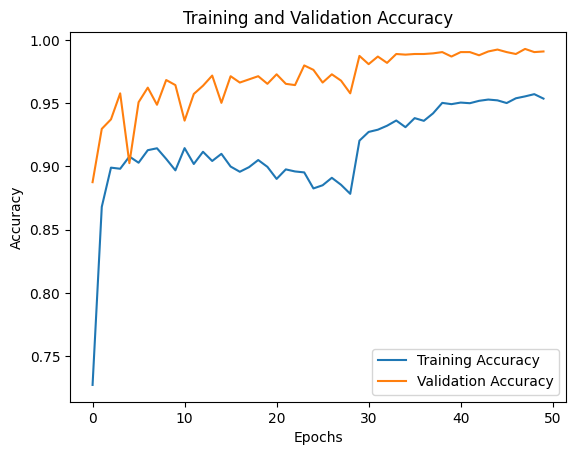

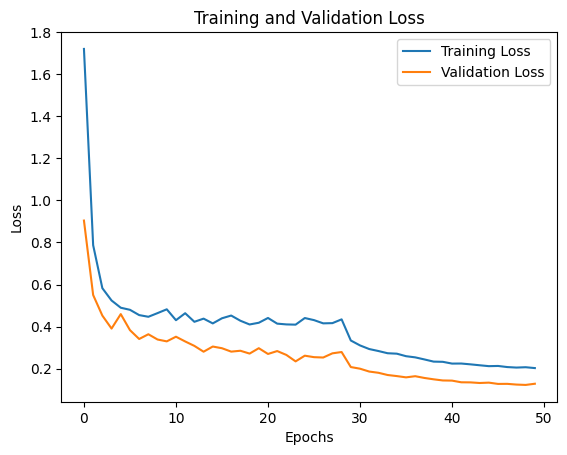

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()